### ETH Whale Activity ML Pipeline

- Setup & Configuration

In [ ]:
import os
import time
import pickle
import requests
import warnings
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix, make_scorer
)

try:
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
    HAS_IMBLEARN = True
except ImportError:
    HAS_IMBLEARN = False
    print("⚠️ imbalanced-learn not installed")

try:
    from xgboost import XGBClassifier
    HAS_XGBOOST = True
except ImportError:
    HAS_XGBOOST = False
    print("⚠️ XGBoost not installed")

from dotenv import load_dotenv

warnings.filterwarnings('ignore')

In [82]:
# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

print(" All imports loaded")

 All imports loaded


- Loading and Configuring Environmental Varriables

In [4]:
# Load API keys
load_dotenv()
DUNE_API_KEY = os.getenv("DUNE_WHALES_API")
COINGECKO_API_KEY = os.getenv("COINGECKO_API_KEY")

if not DUNE_API_KEY or not COINGECKO_API_KEY:
    raise ValueError("❌ Missing API keys in .env file")

# Configuration
QUERY_ID = "6184996"
REQUEST_DELAY = 0.5
OUTPUT_FILE = 'whale_prices_ml_ready.csv'
MODEL_FILE = 'models/eth_price_predictor.pkl'

print(" Configuration loaded")

 Configuration loaded


- Data Collection - Fetch Whale Data from Dune

In [12]:
def fetch_dune_data(query_id, api_key):
    """Execute Dune query and fetch results (excludes today)"""
    print("="*70)
    print(" FETCHING WHALE DATA FROM DUNE ".center(70))
    print("="*70)
    
    headers = {"x-dune-api-key": api_key}
    
    # Execute query
    execute_url = f"https://api.dune.com/api/v1/query/{query_id}/execute"
    execute_response = requests.post(execute_url, headers=headers)
    execute_data = execute_response.json()
    
    execution_id = execute_data.get("execution_id")
    if not execution_id:
        raise ValueError(f"❌ No execution_id: {execute_data}")
    
    print(f"🚀 Execution ID: {execution_id}")
    
    # Poll for completion
    status_url = f"https://api.dune.com/api/v1/execution/{execution_id}/status"
    results_url = f"https://api.dune.com/api/v1/execution/{execution_id}/results"
    
    while True:
        status = requests.get(status_url, headers=headers).json()
        state = status.get("state")
        print(f"State: {state}")
        
        if state == "QUERY_STATE_COMPLETED":
            break
        elif state == "QUERY_STATE_FAILED":
            raise RuntimeError(f"❌ Query failed: {status}")
        time.sleep(10)
    
    # Fetch results
    results = requests.get(results_url, headers=headers).json()
    df = pd.DataFrame(results["result"]["rows"])
    df['block_date'] = pd.to_datetime(df['block_date']).dt.date
    
    # Exclude today
    today = datetime.now().date()
    df = df[df['block_date'] < today]
    
    print(f"✅ Retrieved {len(df)} rows")
    print(f"   Date range: {df['block_date'].min()} → {df['block_date'].max()}")
    return df

df_whales = fetch_dune_data(QUERY_ID, DUNE_API_KEY)

# %%
print(f"\n📊 Whale Data Overview:")
print(f"   Shape: {df_whales.shape}")
print(f"   Columns: {list(df_whales.columns)}")

# Check for rows with zero exchange activity
zero_exchange = df_whales[
    (df_whales['whale_exchange_deposits_weth'] == 0) & 
    (df_whales['whale_exchange_withdrawals_weth'] == 0)
]
print(f"\n   Rows with ZERO exchange activity: {len(zero_exchange)} ({len(zero_exchange)/len(df_whales)*100:.1f}%)")
print(f"   → These represent whale activity OUTSIDE exchanges (OTC, DeFi, cold storage)")
if len(zero_exchange) > 0:
    print(f"   → Avg non-exchange volume on these days: {zero_exchange['non_exchange_volume_weth'].mean():.1f} WETH")

print(f"\n   First 3 rows:")
df_whales.head(3)


                    FETCHING WHALE DATA FROM DUNE                     
🚀 Execution ID: 01KA3JN3VT5NQ1QQH7A9CM2G71
State: QUERY_STATE_EXECUTING
State: QUERY_STATE_EXECUTING
State: QUERY_STATE_EXECUTING
State: QUERY_STATE_EXECUTING
State: QUERY_STATE_COMPLETED
✅ Retrieved 1095 rows
   Date range: 2022-11-16 → 2025-11-14

📊 Whale Data Overview:
   Shape: (1095, 29)
   Columns: ['avg_whale_tx_size_weth', 'block_date', 'deposit_tx_count', 'deposit_withdrawal_ratio', 'exchange_volume_ratio', 'max_whale_tx_size_weth', 'mega_whale_ratio', 'mega_whale_tx_count', 'mega_whale_volume_weth', 'net_flow_ma30', 'net_flow_ma7', 'non_exchange_ratio', 'non_exchange_tx_count', 'non_exchange_volume_weth', 'std_whale_tx_size_weth', 'total_whale_volume_weth', 'volume_ma30', 'volume_ma7', 'volume_std30', 'volume_std7', 'volume_vs_ma30', 'volume_vs_ma7', 'volume_zscore_30d', 'volume_zscore_7d', 'whale_exchange_deposits_weth', 'whale_exchange_withdrawals_weth', 'whale_net_exchange_flow_weth', 'whale_tx_count', 

,avg_whale_tx_size_weth,block_date,deposit_tx_count,deposit_withdrawal_ratio,exchange_volume_ratio,max_whale_tx_size_weth,mega_whale_ratio,mega_whale_tx_count,mega_whale_volume_weth,net_flow_ma30,...,volume_std7,volume_vs_ma30,volume_vs_ma7,volume_zscore_30d,volume_zscore_7d,whale_exchange_deposits_weth,whale_exchange_withdrawals_weth,whale_net_exchange_flow_weth,whale_tx_count,withdrawal_tx_count
0,6298.231853,2025-11-14,0,0.0,0.0,82146.8570,0.9820,1275,3.482762e+07,39.2218,...,8.495260e+06,2.1155,1.5796,3.1052,1.5318,0.0,0.0000,0.0000,3026,0
1,5369.577162,2025-11-13,0,0.0,0.0,110100.7979,0.9789,1392,3.119731e+07,46.3678,...,8.400799e+06,1.9485,1.7541,3.0746,1.6308,0.0,0.0000,0.0000,3212,0
2,4539.905358,2025-11-12,1,1.0,0.0,28262.0000,0.9769,1098,1.971304e+07,34.3884,...,6.149354e+06,1.2547,1.3316,0.9408,0.8172,110.0,109.9997,-0.0003,2346,1


- Function for Price Data - Fetch ETH & BTC Prices

In [13]:

def fetch_coingecko_price(coin_id, from_date, to_date, api_key):
    """Fetch daily prices from CoinGecko Pro API"""
    print(f"\n📈 Fetching {coin_id.upper()} prices: {from_date} → {to_date}")
    
    from_ts = int(pd.Timestamp(from_date).timestamp())
    to_ts = int(pd.Timestamp(to_date).timestamp())
    
    url = f"https://pro-api.coingecko.com/api/v3/coins/{coin_id}/market_chart/range"
    headers = {'accept': 'application/json', 'x-cg-pro-api-key': api_key}
    params = {'vs_currency': 'usd', 'from': from_ts, 'to': to_ts}
    
    try:
        response = requests.get(url, headers=headers, params=params)
        response.raise_for_status()
        data = response.json()
        
        prices = data['prices']
        df = pd.DataFrame({'timestamp': [p[0] for p in prices], 'price': [p[1] for p in prices]})
        df['date'] = pd.to_datetime(df['timestamp'], unit='ms').dt.date
        df = df.groupby('date', as_index=False).agg({'price': 'last'})
        
        print(f"   ✅ {len(df)} days | ${df['price'].min():.0f} - ${df['price'].max():.0f}")
        return df
    except Exception as e:
        print(f"   ❌ Error: {e}")
        return pd.DataFrame()

-  Fetching BTC and ETH Prices

In [14]:

# Determine date range (add 100-day buffer for moving averages)
min_date = pd.to_datetime(df_whales['block_date'].min()) - timedelta(days=100)
max_date = pd.to_datetime(df_whales['block_date'].max())

print(f" Price fetch range: {min_date.date()} → {max_date.date()}")

# Fetch ETH
df_eth = fetch_coingecko_price('ethereum', min_date.strftime('%Y-%m-%d'), 
                                max_date.strftime('%Y-%m-%d'), COINGECKO_API_KEY)
df_eth = df_eth.rename(columns={'price': 'eth_price'})

time.sleep(REQUEST_DELAY)

# Fetch BTC
df_btc = fetch_coingecko_price('bitcoin', min_date.strftime('%Y-%m-%d'),
                                max_date.strftime('%Y-%m-%d'), COINGECKO_API_KEY)
df_btc = df_btc.rename(columns={'price': 'btc_price'})

print(f"\n Price data ready")


 Price fetch range: 2022-08-08 → 2025-11-14

📈 Fetching ETHEREUM prices: 2022-08-08 → 2025-11-14
   ✅ 1195 days | $1095 - $4829

📈 Fetching BITCOIN prices: 2022-08-08 → 2025-11-14
   ✅ 1195 days | $15742 - $124774

 Price data ready


- Data Merging: Dune's Query and Prices from Coingecko

In [15]:
# Merge ETH prices
df_merged = pd.merge(df_whales, df_eth, left_on='block_date', right_on='date', how='inner')
df_merged = df_merged.drop('date', axis=1)

# Merge BTC prices
df_merged = pd.merge(df_merged, df_btc, left_on='block_date', right_on='date', how='inner')
df_merged = df_merged.drop('date', axis=1)

print(f" Merged: {len(df_merged)} rows, {len(df_merged.columns)} columns")


 Merged: 1095 rows, 31 columns


In [32]:
df_merged.shape

(1095, 31)

In [17]:
# ## 5. Feature Engineering

def add_price_features(df, price_col, prefix):
    """Add price-based ML features"""
    df = df.sort_values('block_date').reset_index(drop=True)
    
    # Returns
    df[f'{prefix}_daily_return'] = df[price_col].pct_change()
    df[f'{prefix}_log_return'] = np.log(df[price_col] / df[price_col].shift(1))
    
    # Moving averages
    df[f'{prefix}_ma7'] = df[price_col].rolling(7, min_periods=1).mean()
    df[f'{prefix}_ma30'] = df[price_col].rolling(30, min_periods=1).mean()
    
    # Momentum
    df[f'{prefix}_vs_ma7'] = df[price_col] / df[f'{prefix}_ma7']
    df[f'{prefix}_vs_ma30'] = df[price_col] / df[f'{prefix}_ma30']
    
    # Volatility
    df[f'{prefix}_vol7'] = df[f'{prefix}_daily_return'].rolling(7, min_periods=1).std()
    df[f'{prefix}_vol30'] = df[f'{prefix}_daily_return'].rolling(30, min_periods=1).std()
    
    # Returns
    df[f'{prefix}_ret7d'] = df[price_col].pct_change(7)
    df[f'{prefix}_ret30d'] = df[price_col].pct_change(30)
    
    # RSI
    returns = df[f'{prefix}_daily_return']
    gains = returns.where(returns > 0, 0).rolling(14, min_periods=1).mean()
    losses = -returns.where(returns < 0, 0).rolling(14, min_periods=1).mean()
    rs = gains / (losses + 1e-10)
    df[f'{prefix}_rsi'] = 100 - (100 / (1 + rs))
    
    # Lags
    for lag in [1, 3, 7]:
        df[f'{prefix}_ret_lag{lag}'] = df[f'{prefix}_daily_return'].shift(lag)
    
    return df

# %%
def add_correlation_features(df):
    """Add ETH-BTC correlation features"""
    df['eth_btc_ratio'] = df['eth_price'] / df['btc_price']
    df['eth_btc_ratio_ma7'] = df['eth_btc_ratio'].rolling(7, min_periods=1).mean()
    df['eth_btc_corr_30d'] = df['eth_daily_return'].rolling(30, min_periods=20).corr(df['btc_daily_return'])
    df['eth_outperformance'] = df['eth_daily_return'] - df['btc_daily_return']
    return df

# %%
def create_target(df):
    """Create target: next day price direction"""
    df['next_day_return'] = df['eth_price'].pct_change().shift(-1)
    df['next_day_price_direction'] = (df['next_day_return'] > 0).astype(int)
    return df

# %%
print("\n⚙️ Engineering features...")

df_merged = add_price_features(df_merged, 'eth_price', 'eth')
df_merged = add_price_features(df_merged, 'btc_price', 'btc')
df_merged = add_correlation_features(df_merged)
df_merged = create_target(df_merged)

print(f"✅ Features created: {len(df_merged.columns)} total columns")

# %%
# Drop rows with NaN target
df_final = df_merged.dropna(subset=['next_day_price_direction']).copy()

print(f"✅ Final dataset: {len(df_final)} rows")
print(f"   Dropped {len(df_merged) - len(df_final)} rows (NaN target)")

# Save
df_final.to_csv(OUTPUT_FILE, index=False)
print(f"💾 Saved: {OUTPUT_FILE}")



⚙️ Engineering features...
✅ Features created: 65 total columns
✅ Final dataset: 1095 rows
   Dropped 0 rows (NaN target)
💾 Saved: whale_prices_ml_ready.csv


In [18]:
# ## 6. Exploratory Data Analysis (EDA)

# %%
print("\n" + "="*70)
print(" EXPLORATORY DATA ANALYSIS ".center(70))
print("="*70)

print(f"\n📊 Dataset: {len(df_final):,} rows × {len(df_final.columns)} columns")
print(f"📅 Date range: {df_final['block_date'].min()} → {df_final['block_date'].max()}")


                      EXPLORATORY DATA ANALYSIS                       

📊 Dataset: 1,095 rows × 65 columns
📅 Date range: 2022-11-16 → 2025-11-14


In [35]:
# %%
# Target distribution
print("\n🎯 Target Distribution:")
print(df_final['next_day_price_direction'].value_counts())
print(f"   Positive class: {df_final['next_day_price_direction'].mean()*100:.1f}%")




🎯 Target Distribution:
next_day_price_direction
1    561
0    534
Name: count, dtype: int64
   Positive class: 51.2%


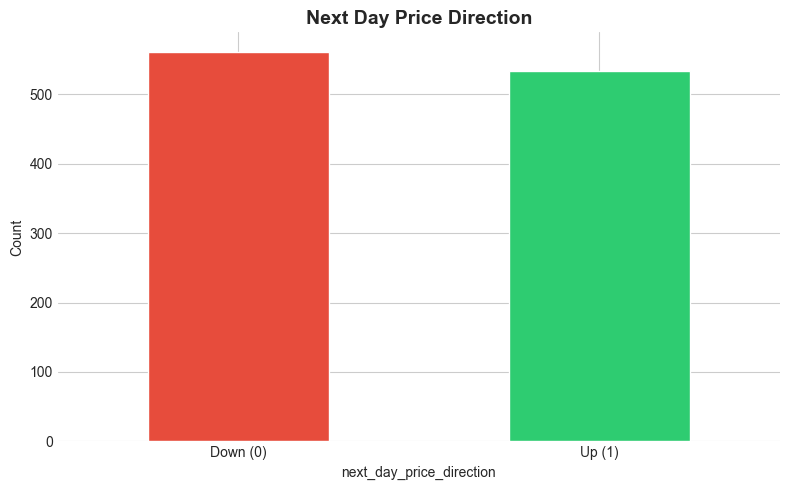

In [ ]:
# %%
# Plot target
fig, ax = plt.subplots(figsize=(8, 5))
df_final['next_day_price_direction'].value_counts().plot(kind='bar', ax=ax, color=['#e74c3c', '#2ecc71'])
ax.set_title('Next Day Price Direction', fontsize=14, fontweight='bold')
ax.set_xticklabels(['Down (0)', 'Up (1)'], rotation=0)
ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

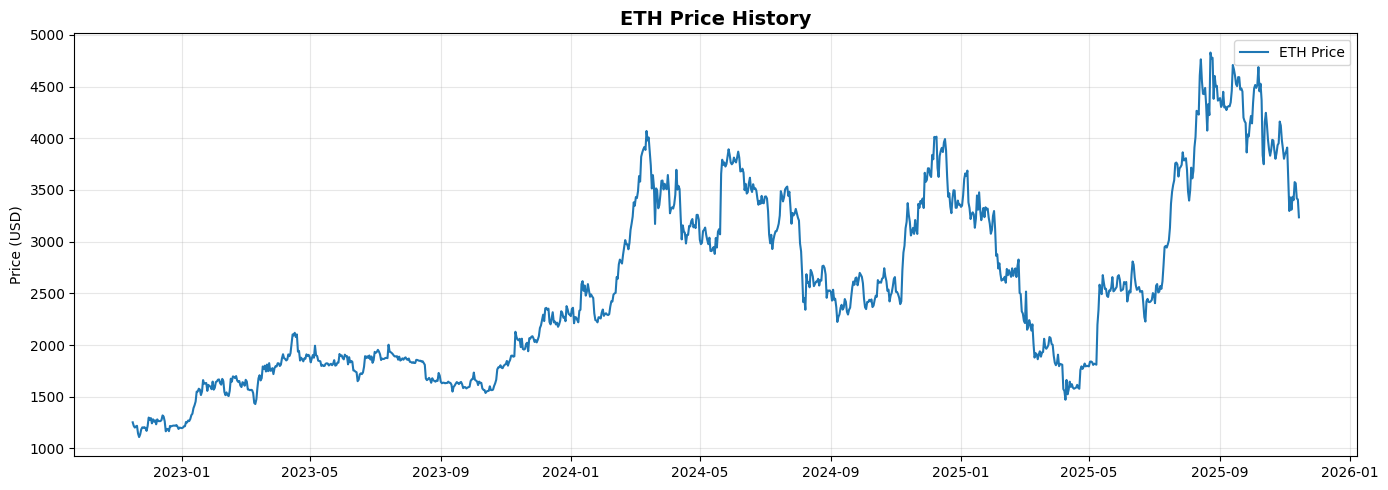

In [20]:
# Price over time
fig, ax = plt.subplots(figsize=(14, 5))
dates = pd.to_datetime(df_final['block_date'])
ax.plot(dates, df_final['eth_price'], linewidth=1.5, label='ETH Price')
ax.set_title('ETH Price History', fontsize=14, fontweight='bold')
ax.set_ylabel('Price (USD)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



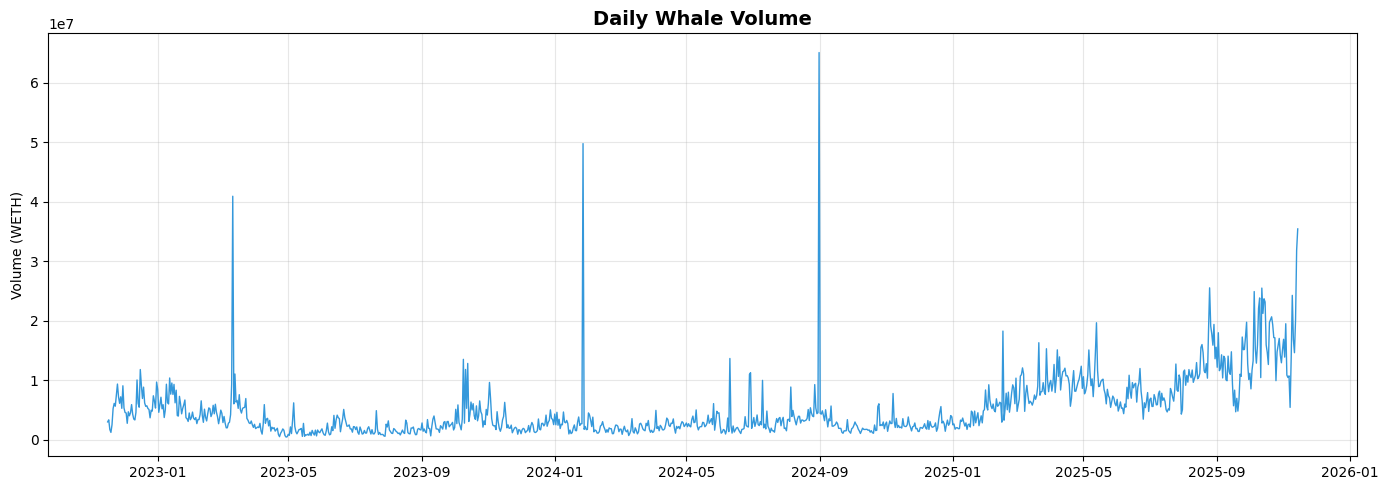

In [21]:
# Whale volume over time
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(dates, df_final['total_whale_volume_weth'], linewidth=1, color='#3498db')
ax.set_title('Daily Whale Volume', fontsize=14, fontweight='bold')
ax.set_ylabel('Volume (WETH)')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



In [22]:
# %%
# Correlation with target
print("\n📈 Top 15 Features Correlated with Target:")
numeric_cols = df_final.select_dtypes(include=[np.number]).columns
corr = df_final[numeric_cols].corr()['next_day_price_direction'].abs().sort_values(ascending=False)
print(corr.head(15))




📈 Top 15 Features Correlated with Target:
next_day_price_direction        1.000000
next_day_return                 0.687797
volume_vs_ma7                   0.074161
volume_vs_ma30                  0.068639
whale_net_exchange_flow_weth    0.068381
eth_daily_return                0.067209
eth_log_return                  0.067027
btc_daily_return                0.065785
btc_log_return                  0.065319
volume_zscore_30d               0.065289
volume_zscore_7d                0.058076
btc_ret_lag1                    0.053639
non_exchange_volume_weth        0.047612
total_whale_volume_weth         0.047612
mega_whale_volume_weth          0.047228
Name: next_day_price_direction, dtype: float64


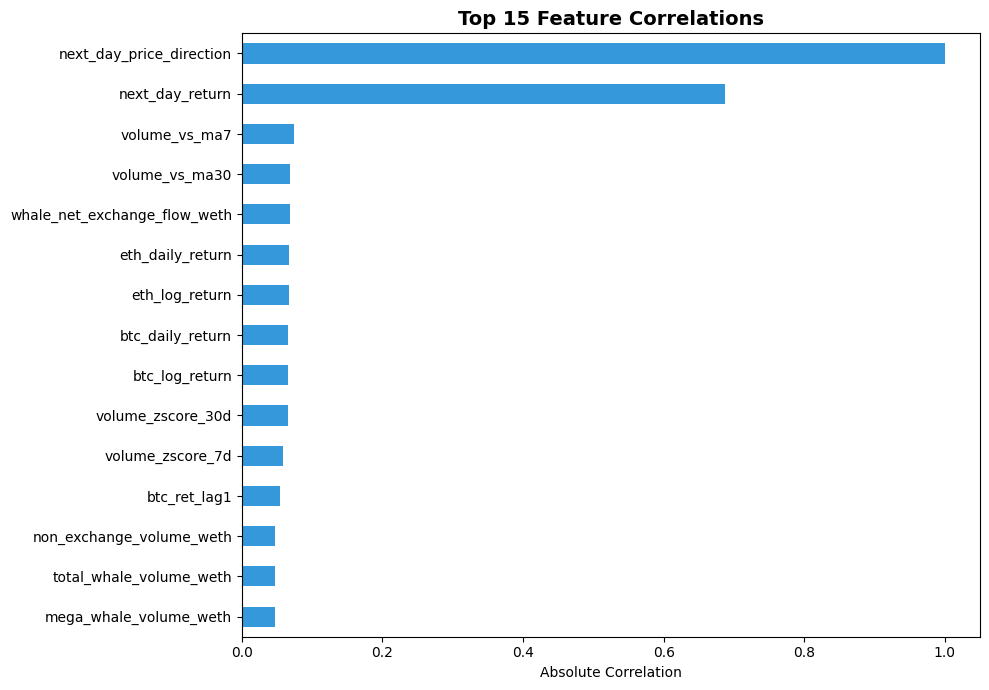

In [23]:

# Plot correlations
fig, ax = plt.subplots(figsize=(10, 7))
corr.head(15).sort_values().plot(kind='barh', ax=ax, color='#3498db')
ax.set_title('Top 15 Feature Correlations', fontsize=14, fontweight='bold')
ax.set_xlabel('Absolute Correlation')
plt.tight_layout()
plt.show()


- Model Training Pipeline

In [24]:
print()
print(" Leak Features ".center(70))
print()

# Define leakage features to exclude
LEAKAGE_FEATURES = [
    'next_day_return',  # Contains future information!
    'next_day_price_movement',  # Also future info
    'block_date', 
    'date', 
    'timestamp'
]

print(f"Leakage features to remove: {LEAKAGE_FEATURES}")


                            Leak Features                             

Leakage features to remove: ['next_day_return', 'next_day_price_movement', 'block_date', 'date', 'timestamp']


- Prepare The Data

In [25]:
def prepare_features(df, target='next_day_price_direction'):
    """Prepare clean features without data leakage"""
    data = df.copy()
    
    # Remove leakage
    leakage_found = [col for col in LEAKAGE_FEATURES if col in data.columns]
    if leakage_found:
        data = data.drop(columns=leakage_found)
        print(f" Removed {len(leakage_found)} leakage features")
    
    # Select numeric features
    feature_cols = [col for col in data.columns 
                   if col != target and pd.api.types.is_numeric_dtype(data[col])]
    
    # Handle inf/nan
    data[feature_cols] = data[feature_cols].replace([np.inf, -np.inf], np.nan)
    data[feature_cols] = data[feature_cols].fillna(method='ffill').fillna(data[feature_cols].median())
    
    print(f"Prepared {len(feature_cols)} features")
    return data, feature_cols


In [26]:
def time_split(X, y, train_ratio=0.6, val_ratio=0.2):
    """Time-based train/val/test split"""
    N = len(X)
    train_size = int(N * train_ratio)
    val_size = int(N * val_ratio)
    
    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
    X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]
    
    print(f"\n Data split:")
    print(f"   Train: {len(X_train)} ({len(X_train)/N*100:.1f}%)")
    print(f"   Val:   {len(X_val)} ({len(X_val)/N*100:.1f}%)")
    print(f"   Test:  {len(X_test)} ({len(X_test)/N*100:.1f}%)")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

- Split data and Scale Features


In [35]:
data, feature_cols = prepare_features(df_final)
X = data[feature_cols].values
y = data['next_day_price_direction'].values

X_train, X_val, X_test, y_train, y_val, y_test = time_split(X, y)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


 Removed 2 leakage features
Prepared 62 features

 Data split:
   Train: 657 (60.0%)
   Val:   219 (20.0%)
   Test:  219 (20.0%)


- Handle class imbalance

In [34]:
if HAS_IMBLEARN:
    print("\n Applying SMOTE...")
    smote = SMOTE(random_state=42)
    X_train_final, y_train_final = smote.fit_resample(X_train_scaled, y_train)
    print(f"   After SMOTE: {np.bincount(y_train_final.astype(int))}")
else:
    X_train_final, y_train_final = X_train_scaled, y_train



 Applying SMOTE...
   After SMOTE: [337 337]


- Hyperparameter Tuning with RandomizedSearchCV

In [36]:
print("\n" + "="*70)
print(" HYPERPARAMETER TUNING ".center(70))
print("="*70)

# Define parameter grids
param_grids = {
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42, n_jobs=-1),
        'params': {
            'n_estimators': [100, 200, 300, 500],
            'max_depth': [5, 10, 15, 20, None],
            'min_samples_split': [2, 5, 10, 20],
            'min_samples_leaf': [1, 2, 4, 8],
            'class_weight': ['balanced', 'balanced_subsample', None],
            'max_features': ['sqrt', 'log2', None]
        }
    }
}

if HAS_XGBOOST:
    param_grids['XGBoost'] = {
        'model': XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 5, 7, 10],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'scale_pos_weight': [0.8, 1.0, 1.2, 1.5]
        }
    }

# Custom scoring function (balance accuracy and recall)
def custom_score(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, zero_division=0)
    # Weight recall more to avoid conservative predictions
    return 0.4 * acc + 0.6 * recall

scorer = make_scorer(custom_score)

# %%
tuning_results = {}

for name, config in param_grids.items():
    print(f"\n🔧 Tuning {name}...")
    print(f"   Parameter combinations to try: {len(config['params'])} parameters")
    
    # Use RandomizedSearchCV for efficiency
    search = RandomizedSearchCV(
        config['model'],
        config['params'],
        n_iter=20,  # Try 20 random combinations
        scoring=scorer,
        cv=3,  # 3-fold time-series aware CV
        random_state=42,
        n_jobs=-1,
        verbose=1
    )
    
    search.fit(X_train_final, y_train_final)
    
    # Evaluate on validation set
    val_preds = search.best_estimator_.predict(X_val_scaled)
    val_acc = accuracy_score(y_val, val_preds)
    val_recall = recall_score(y_val, val_preds, zero_division=0)
    val_auc = roc_auc_score(y_val, search.best_estimator_.predict_proba(X_val_scaled)[:, 1])
    
    tuning_results[name] = {
        'model': search.best_estimator_,
        'params': search.best_params_,
        'val_accuracy': val_acc,
        'val_recall': val_recall,
        'val_auc': val_auc,
        'custom_score': custom_score(y_val, val_preds)
    }
    
    print(f"\n   ✅ Best parameters: {search.best_params_}")
    print(f"   Val Accuracy: {val_acc:.4f}")
    print(f"   Val Recall:   {val_recall:.4f}")
    print(f"   Val AUC:      {val_auc:.4f}")
    print(f"   Custom Score: {tuning_results[name]['custom_score']:.4f}")



                        HYPERPARAMETER TUNING                         

🔧 Tuning Random Forest...
   Parameter combinations to try: 6 parameters
Fitting 3 folds for each of 20 candidates, totalling 60 fits

   ✅ Best parameters: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': None, 'max_depth': None, 'class_weight': 'balanced'}
   Val Accuracy: 0.5160
   Val Recall:   0.5185
   Val AUC:      0.5354
   Custom Score: 0.5175

🔧 Tuning XGBoost...
   Parameter combinations to try: 6 parameters
Fitting 3 folds for each of 20 candidates, totalling 60 fits

   ✅ Best parameters: {'subsample': 1.0, 'scale_pos_weight': 1.5, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
   Val Accuracy: 0.5388
   Val Recall:   0.7870
   Val AUC:      0.5546
   Custom Score: 0.6877


 - Select Best Model

In [41]:
print(" MODEL COMPARISON ".center(70))

for name, result in tuning_results.items():
    print(f"\n{name}:")
    print(f"  Val Accuracy: {result['val_accuracy']:.4f}")
    print(f"  Val Recall:   {result['val_recall']:.4f}")
    print(f"  Val AUC:      {result['val_auc']:.4f}")
    print(f"  Custom Score: {result['custom_score']:.4f}")

# Select best based on custom score
best_name = max(tuning_results.items(), key=lambda x: x[1]['custom_score'])[0]
best_model = tuning_results[best_name]['model']

print(f"\n Best Model: {best_name}")
print(f"   Custom Score: {tuning_results[best_name]['custom_score']:.4f}")


                           MODEL COMPARISON                           

Random Forest:
  Val Accuracy: 0.5160
  Val Recall:   0.5185
  Val AUC:      0.5354
  Custom Score: 0.5175

XGBoost:
  Val Accuracy: 0.5388
  Val Recall:   0.7870
  Val AUC:      0.5546
  Custom Score: 0.6877

 Best Model: XGBoost
   Custom Score: 0.6877


 - Retrain on Train+Val and Evaluate on Test


In [43]:
print("\n" + "="*70)
print(" FINAL TRAINING ON TRAIN + VAL ".center(70))
print("="*70)

X_full = np.vstack([X_train, X_val])
y_full = np.concatenate([y_train, y_val])

scaler.fit(X_full)
X_full_scaled = scaler.transform(X_full)
X_test_scaled = scaler.transform(X_test)

if HAS_IMBLEARN:
    X_full_final, y_full_final = SMOTE(random_state=42).fit_resample(X_full_scaled, y_full)
else:
    X_full_final, y_full_final = X_full_scaled, y_full

best_model.fit(X_full_final, y_full_final)
print(f"✅ Retrained {best_model.__class__.__name__}")

print("\n" + "="*70)
print(" FINAL EVALUATION ON TEST SET ".center(70))
print("="*70)

y_pred = best_model.predict(X_test_scaled)
y_proba = best_model.predict_proba(X_test_scaled)[:, 1]

acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
auc = roc_auc_score(y_test, y_proba)

print(f"\n📊 Test Performance:")
print(f"   Accuracy:  {acc:.4f}")
print(f"   Precision: {precision:.4f}")
print(f"   Recall:    {recall:.4f}")
print(f"   F1-Score:  {f1:.4f}")
print(f"   AUC:       {auc:.4f}")

print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Down', 'Up']))



                    FINAL TRAINING ON TRAIN + VAL                     
✅ Retrained XGBClassifier

                     FINAL EVALUATION ON TEST SET                     

📊 Test Performance:
   Accuracy:  0.5434
   Precision: 0.5541
   Recall:    0.7069
   F1-Score:  0.6212
   AUC:       0.5456

📋 Classification Report:
              precision    recall  f1-score   support

        Down       0.52      0.36      0.43       103
          Up       0.55      0.71      0.62       116

    accuracy                           0.54       219
   macro avg       0.54      0.53      0.52       219
weighted avg       0.54      0.54      0.53       219



 - Confusion Matrix

In [46]:
cm = confusion_matrix(y_test, y_pred)
print("\n Confusion Matrix:")
print(f"              Predicted")
print(f"              Down    Up")
print(f"Actual Down   {cm[0,0]:4d}  {cm[0,1]:4d}")
print(f"       Up     {cm[1,0]:4d}  {cm[1,1]:4d}")


 Confusion Matrix:
              Predicted
              Down    Up
Actual Down     37    66
       Up       34    82


- Feature importance


In [48]:
if hasattr(best_model, 'feature_importances_'):
    print(" TOP 20 FEATURE IMPORTANCES ".center(70))
       
    importance = pd.Series(best_model.feature_importances_, 
                          index=feature_cols).sort_values(ascending=False)
    
    for i, (feat, imp) in enumerate(importance.head(20).items(), 1):
        print(f"{i:2d}. {feat:45s} {imp:.6f}")    


                      TOP 20 FEATURE IMPORTANCES                      
 1. max_whale_tx_size_weth                        0.031857
 2. std_whale_tx_size_weth                        0.028676
 3. eth_log_return                                0.025445
 4. eth_daily_return                              0.025069
 5. volume_vs_ma7                                 0.023738
 6. volume_zscore_7d                              0.023462
 7. btc_price                                     0.020509
 8. deposit_withdrawal_ratio                      0.020457
 9. btc_vs_ma30                                   0.020426
10. non_exchange_volume_weth                      0.020322
11. whale_exchange_withdrawals_weth               0.019390
12. btc_vol7                                      0.019113
13. total_whale_volume_weth                       0.019029
14. avg_whale_tx_size_weth                        0.018997
15. eth_btc_ratio_ma7                             0.018883
16. eth_ma30                                

- Save Model

In [56]:
os.makedirs('models', exist_ok=True)

model_dict = {
    'model': best_model,
    'scaler': scaler,
    'feature_names': feature_cols,
    'target': 'next_day_price_direction',
    'model_name': best_name,
    'best_params': tuning_results[best_name]['params'],
    'trained_date': datetime.now().isoformat(),
    'test_accuracy': acc,
    'test_recall': recall,
    'test_precision': precision,
    'test_f1': f1,
    'test_auc': auc
}

MODEL_FILE = 'models/best_model.pkl'


with open(MODEL_FILE, 'wb') as f:
    pickle.dump(model_dict, f)

print(f"\n Best model saved: {MODEL_FILE}")
print()
print(" PIPELINE COMPLETE ".center(70))

print(f"\n Summary:")
print(f"   Dataset: {len(df_final):,} rows")
print(f"   Features: {len(feature_cols)}")
print(f"   Best Model: {best_name}")
print(f"   Best Params: {tuning_results[best_name]['params']}")
print(f"   Test Accuracy: {acc:.4f}")
print(f"   Test Recall: {recall:.4f}")
print(f"   Test AUC: {auc:.4f}")
print(f"   Test_f1: {f1:.4f}")


 Best model saved: models/best_model.pkl

                          PIPELINE COMPLETE                           

 Summary:
   Dataset: 1,095 rows
   Features: 62
   Best Model: XGBoost
   Best Params: {'subsample': 1.0, 'scale_pos_weight': 1.5, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
   Test Accuracy: 0.5434
   Test Recall: 0.7069
   Test AUC: 0.5456
   Test_f1: 0.6212
